In [2]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


##Clustering current matrix by mutation profile

In [3]:
patient_mutations = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_mutations.csv', index_col=0)

Get frequency of each mutation in each tumor type

In [14]:
patient_tissues = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_tissues.csv', index_col=0)
patient_tissues = patient_tissues.ix[[x for x in patient_mutations.index if x in patient_tissues.index]]

In [71]:
patients_in_both = [x for x in patient_mutations.index if x in patient_tissues.index]

In [52]:
tissues = patient_tissues.Tissue.unique()

In [53]:
df = pd.DataFrame(np.nan, index=patient_mutations.columns, columns=[])
for tissue in tissues:
    patients_with_tissue = patient_tissues[patient_tissues.Tissue == tissue].index
    df[tissue] = patient_mutations.ix[patients_with_tissue].sum() / len(patients_with_tissue)

In [59]:
df = df[df.sum(axis=1) > 0.05]

In [60]:
df.shape

(78, 28)

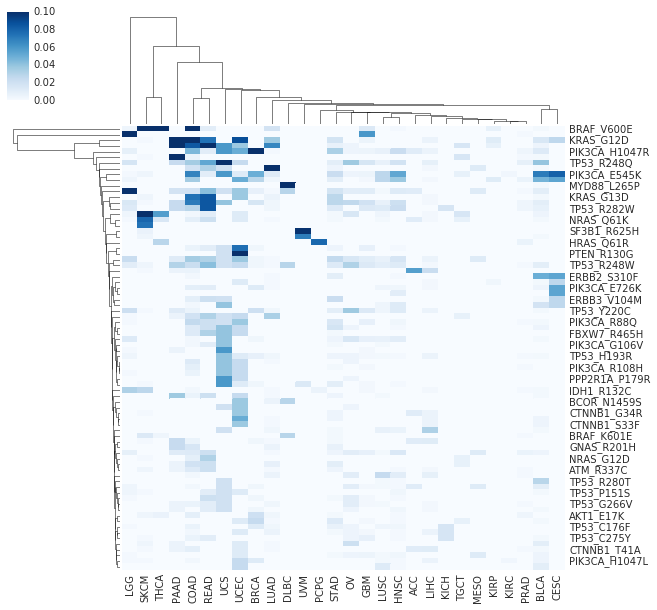

In [155]:
sns.clustermap(df, cmap='Blues', vmax=0.1)

In [62]:
groups = [['SKCM', 'THCA'],
          ['PAAD', 'COAD', 'READ', 'UCS', 'UCEC'],
          ['STAD', 'OV', 'GBM', 'LUSC', 'HNSC'],
          ['BLCA', 'CESC']]

In [85]:
group = groups[0]
group = ['SKCM']
def is_tissue(x):
    if x in group:
        return 1
    else:
        return 0
patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)
weight_shift = float(len(patient_tissues[patient_tissues.is_tissue == 0]))/len(patient_tissues[patient_tissues.is_tissue == 1])
print weight_shift

15.1095571096


In [86]:
X = patient_mutations.ix[patients_in_both].as_matrix()
Y = patient_tissues.ix[patients_in_both].is_tissue
clf = RandomForestClassifier(random_state=0, oob_score=True, class_weight={1:weight_shift, 0:1})
clf.fit(X, Y)
clf.oob_score_

0.92070612067718127

In [87]:
random_oob = []
for i in range(10):
    print i
    random.shuffle(Y)
    clf.fit(X, Y)
    random_oob.append(clf.oob_score_)

0
1
2
3
4
5
6
7
8
9


### Heatmap for OOB accuracy for individual tumors

In [126]:
OOBs, precision, recall = [], [], []
for tissue in tissues:
    group = [tissue]
    
    # format labels
    def is_tissue(x):
        if x in group:
            return 1
        else:
            return 0
    patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)
    weight_shift = float(len(patient_tissues[patient_tissues.is_tissue == 0]))/len(patient_tissues[patient_tissues.is_tissue == 1])
    
    
    # Train predictor
    X = patient_mutations.ix[patients_in_both].as_matrix()
    Y = patient_tissues.ix[patients_in_both].is_tissue
    clf = RandomForestClassifier(random_state=0, oob_score=True, class_weight={1:weight_shift, 0:1})
    clf.fit(X, Y)
    OOBs.append(clf.oob_score_)
    positives = clf.predict(patient_mutations.ix[patient_tissues[patient_tissues.Tissue.isin(group)].index].as_matrix())
    negatives = clf.predict(patient_mutations.ix[patient_tissues[~patient_tissues.Tissue.isin(group)].index].as_matrix())
    precision.append(float(sum(positives))/(sum(positives)+sum(negatives)))
    recall.append(float(sum(positives))/len(positives))

In [127]:
tissue_results = pd.DataFrame({'Tissue': tissues,
                        'OOB_accuracy': OOBs,
                        'Precision': precision,
                        'Recall': recall})

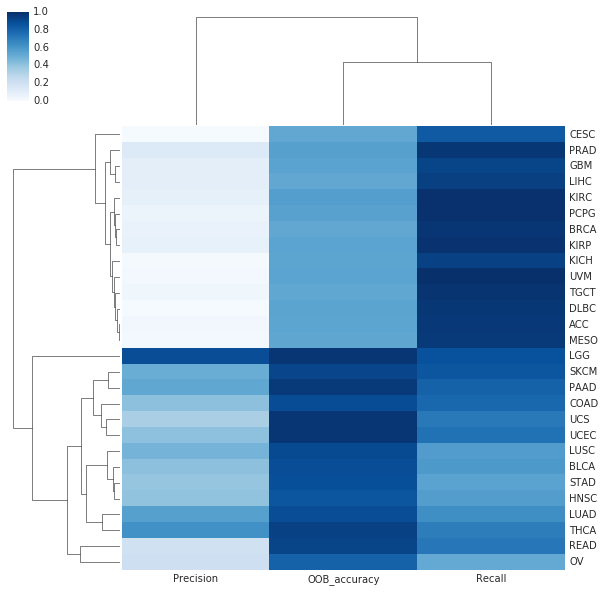

In [128]:
sns.clustermap(tissue_results[['OOB_accuracy', 'Precision', 'Recall']], yticklabels=tissue_results.Tissue, 
               cmap='Blues', vmax=1, vmin=0)

### Heatmap for OOB accuracy for grouped tumors

In [129]:
OOBs, precision, recall = [], [], []
for group in groups:
    
    # format labels
    def is_tissue(x):
        if x in group:
            return 1
        else:
            return 0
    patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)
    weight_shift = float(len(patient_tissues[patient_tissues.is_tissue == 0]))/len(patient_tissues[patient_tissues.is_tissue == 1])
    
    
    # Train predictor
    X = patient_mutations.ix[patients_in_both].as_matrix()
    Y = patient_tissues.ix[patients_in_both].is_tissue
    clf = RandomForestClassifier(random_state=0, oob_score=True, class_weight={1:weight_shift, 0:1})
    clf.fit(X, Y)
    OOBs.append(clf.oob_score_)
    positives = clf.predict(patient_mutations.ix[patient_tissues[patient_tissues.Tissue.isin(group)].index].as_matrix())
    negatives = clf.predict(patient_mutations.ix[patient_tissues[~patient_tissues.Tissue.isin(group)].index].as_matrix())
    precision.append(float(sum(positives))/(sum(positives)+sum(negatives)))
    recall.append(float(sum(positives))/len(positives))

In [140]:
grouped_results = pd.DataFrame({'Tissue': [','.join(x) for x in groups],
                        'OOB_accuracy': OOBs,
                        'Precision': precision,
                        'Recall': recall})

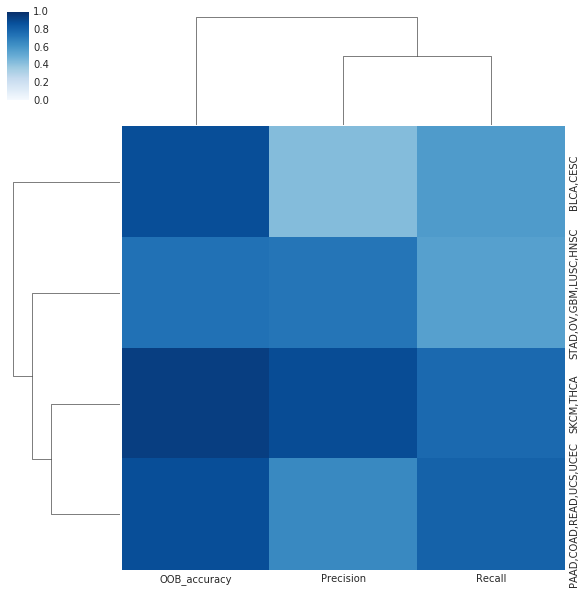

In [141]:
sns.clustermap(grouped_results[['OOB_accuracy', 'Precision', 'Recall']], yticklabels=grouped_results.Tissue, 
               cmap='Blues', vmax=1, vmin=0)

Visualized together

In [142]:
results = pd.concat([tissue_results, grouped_results])

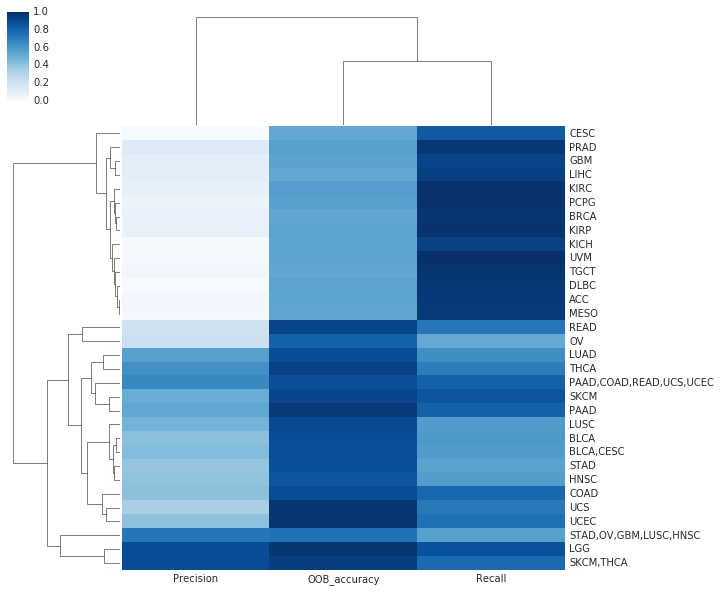

In [143]:
sns.clustermap(results[['OOB_accuracy', 'Precision', 'Recall']], yticklabels=results.Tissue, 
               cmap='Blues', vmax=1, vmin=0)

## Predicting from PHBR scores

In [146]:
classI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_i.csv', index_col=0)
classII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_ii.csv', index_col=0)
patient_PHBRs = pd.concat([pd.concat([classI.transpose(), classII.transpose()]).transpose()])

In [147]:
OOBs, precision, recall = [], [], []
for tissue in tissues:
    group = [tissue]
    
    # format labels
    def is_tissue(x):
        if x in group:
            return 1
        else:
            return 0
    patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)
    weight_shift = float(len(patient_tissues[patient_tissues.is_tissue == 0]))/len(patient_tissues[patient_tissues.is_tissue == 1])
    
    
    # Train predictor
    X = patient_PHBRs.ix[patients_in_both].as_matrix()
    Y = patient_tissues.ix[patients_in_both].is_tissue
    clf = RandomForestClassifier(random_state=0, oob_score=True, class_weight={1:weight_shift, 0:1})
    clf.fit(X, Y)
    OOBs.append(clf.oob_score_)
    positives = clf.predict(patient_PHBRs.ix[patient_tissues[patient_tissues.Tissue.isin(group)].index].as_matrix())
    negatives = clf.predict(patient_PHBRs.ix[patient_tissues[~patient_tissues.Tissue.isin(group)].index].as_matrix())
    precision.append(float(sum(positives))/(sum(positives)+sum(negatives)))
    recall.append(float(sum(positives))/len(positives))

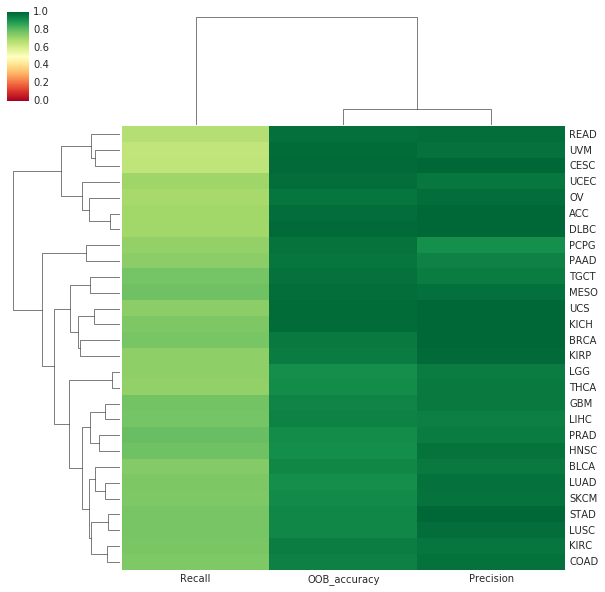

In [150]:
tissue_results = pd.DataFrame({'Tissue': tissues,
                        'OOB_accuracy': OOBs,
                        'Precision': precision,
                        'Recall': recall})
sns.clustermap(tissue_results[['OOB_accuracy', 'Precision', 'Recall']], yticklabels=tissue_results.Tissue, 
               cmap='RdYlGn', vmax=1, vmin=0)

In [151]:
OOBs, precision, recall = [], [], []
for group in groups:
    
    # format labels
    def is_tissue(x):
        if x in group:
            return 1
        else:
            return 0
    patient_tissues['is_tissue'] = patient_tissues['Tissue'].apply(is_tissue)
    weight_shift = float(len(patient_tissues[patient_tissues.is_tissue == 0]))/len(patient_tissues[patient_tissues.is_tissue == 1])
    
    
    # Train predictor
    X = patient_PHBRs.ix[patients_in_both].as_matrix()
    Y = patient_tissues.ix[patients_in_both].is_tissue
    
    clf = RandomForestClassifier(random_state=0, oob_score=True, class_weight={1:weight_shift, 0:1})
    clf.fit(X, Y)
    OOBs.append(clf.oob_score_)
    positives = clf.predict(patient_PHBRs.ix[patient_tissues[patient_tissues.Tissue.isin(group)].index].as_matrix())
    negatives = clf.predict(patient_PHBRs.ix[patient_tissues[~patient_tissues.Tissue.isin(group)].index].as_matrix())
    precision.append(float(sum(positives))/(sum(positives)+sum(negatives)))
    recall.append(float(sum(positives))/len(positives))

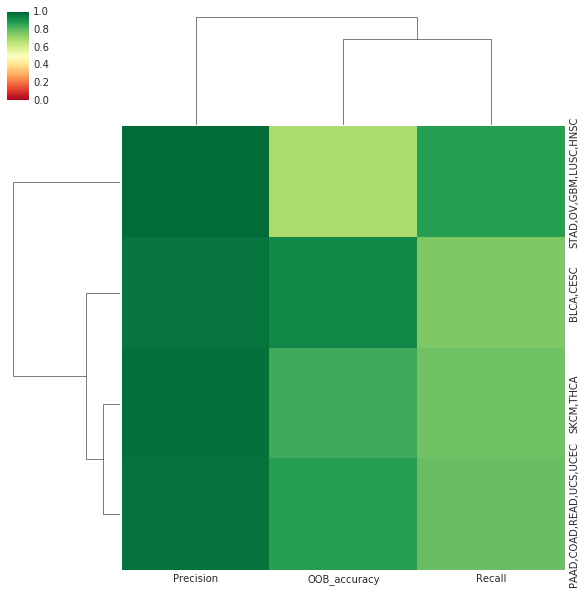

In [153]:
grouped_results = pd.DataFrame({'Tissue': [','.join(x) for x in groups],
                        'OOB_accuracy': OOBs,
                        'Precision': precision,
                        'Recall': recall})
sns.clustermap(grouped_results[['OOB_accuracy', 'Precision', 'Recall']], yticklabels=grouped_results.Tissue, 
               cmap='RdYlGn', vmax=1, vmin=0)

Visualize together

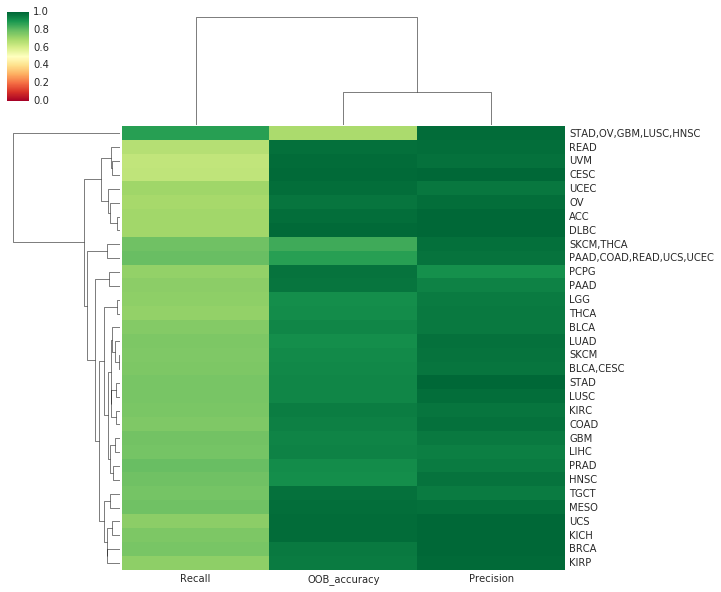

In [154]:
results = pd.concat([tissue_results, grouped_results])
sns.clustermap(results[['OOB_accuracy', 'Precision', 'Recall']], yticklabels=results.Tissue, 
               cmap='RdYlGn', vmax=1, vmin=0)